# Satelittes mission data with python
Notebook contains script that allows to calculate and plot data needed to plan/perform satellite's on-orbit mission.

## 1 Init

### 1.1 Import needed libs
* skyfield - astronomy computation package
* cartopy - geospatial data processing package
* matplotlib - data visualization package
* pyIGRF - IGRF computation package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from skyfield import api as sf
from skyfield.toposlib import Topos
import cartopy.crs as ccrs
import requests
import pandas as pd
import pyIGRF
import numpy as np

### 1.2 Select satellite and time range

In [2]:
celestrak_base_url = 'https://celestrak.com/NORAD/elements/gp.php'
format_url_param = 'FORMAT=tle'
base_query_url = f'{celestrak_base_url}?{format_url_param}'
sat_selector_def = 'SENTINEL-2A'
sat_selector = input(f'satellite ID / name: (def: {sat_selector_def})') or sat_selector_def 
if sat_selector.isnumeric():
    response = requests.get(f'{base_query_url}&CATNR={sat_selector}')
else:
    response = requests.get(f'{base_query_url}&NAME={sat_selector}')

tle = response.text.splitlines()
ts = sf.load.timescale()
satellite = sf.EarthSatellite(tle[1], tle[2], tle[0], ts)
print(satellite)

satellite ID / name: (def: SENTINEL-2A) 


SENTINEL-2A catalog #40697 epoch 2021-02-20 12:21:53 UTC


In [3]:
from datetime import datetime, timezone, timedelta
start_time_str_def = datetime.utcnow().replace(tzinfo=timezone.utc).isoformat()
start_time_str = input(f'start time: (def: {start_time_str_def})') or start_time_str_def
start_time = datetime.fromisoformat(start_time_str).replace(tzinfo=timezone.utc)
print(start_time.isoformat())

end_time_str_def = (start_time + timedelta(days=1)).isoformat()
end_time_str = input(f'end time: (def: {end_time_str_def})') or end_time_str_def
end_time = datetime.fromisoformat(end_time_str).replace(tzinfo=timezone.utc)
print(end_time.isoformat())

time_freq = '30S'
time_list = pd.date_range(start_time,end_time,freq=time_freq)
sf_time_list = ts.from_datetimes(time_list)

start time: (def: 2021-02-20T21:07:44.503826+00:00) 


2021-02-20T21:07:44.503826+00:00


end time: (def: 2021-02-21T21:07:44.503826+00:00) 


2021-02-21T21:07:44.503826+00:00


## 2 Mission data

### 2.1 Satellite position
The position of the satellite is calculated for the given time range. Both the ICRF geocentric position and the topos geographic position (latitude, longitude, elevation) are computed.

In [4]:
positions = [satellite.at(t) for t in sf_time_list]

#### 2.1.1 Geocentric ICRF position

In [5]:
icrf_positions = [p.position for p in positions]

x = [p.km[0] for p in icrf_positions]
y = [p.km[1] for p in icrf_positions]
z = [p.km[2] for p in icrf_positions]

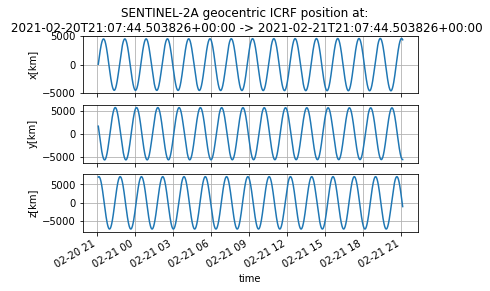

In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_ylabel('x[km]')
ax1.set_xlabel('time')
ax1.plot(time_list, x)
ax2 = fig.add_subplot(3, 1, 2)
ax2.set_ylabel('y[km]')
ax2.set_xlabel('time')
ax2.plot(time_list, y)
ax3 = fig.add_subplot(3, 1, 3)
ax3.set_ylabel('z[km]')
ax3.set_xlabel('time')
ax3.plot(time_list, z)
ax1.grid()
ax2.grid()
ax3.grid()
plt.gcf().autofmt_xdate()
fig.suptitle(f'{satellite.name} geocentric ICRF position at:\n {time_list[0].isoformat()} -> {time_list[-1].isoformat()}')
plt.show()

#### 2.1.2 Geographic topos position

In [7]:
topos_positions = [p.subpoint() for p in positions]

latitudes = [p.latitude.degrees for p in topos_positions]
longitudes = [p.longitude.degrees for p in topos_positions]
elevations = [p.elevation.km for p in topos_positions]

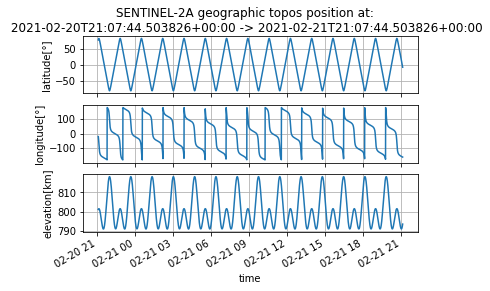

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_ylabel('latitude[°]')
ax1.set_xlabel('time')
ax1.plot(time_list, latitudes)
ax2 = fig.add_subplot(3, 1, 2)
ax2.set_ylabel('longitude[°]')
ax2.set_xlabel('time')
ax2.plot(time_list, longitudes)
ax3 = fig.add_subplot(3, 1, 3)
ax3.set_ylabel('elevation[km]')
ax3.set_xlabel('time')
ax3.plot(time_list, elevations)
ax1.grid()
ax2.grid()
ax3.grid()
plt.gcf().autofmt_xdate()
fig.suptitle(f'{satellite.name} geographic topos position at:\n {time_list[0].isoformat()} -> {time_list[-1].isoformat()}')
plt.show()

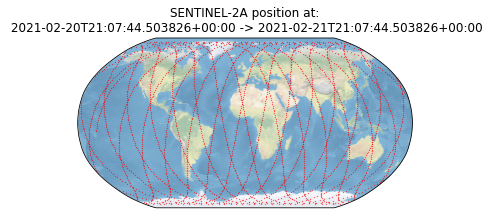

In [9]:
ax = plt.axes(projection=ccrs.Robinson())
ax.stock_img()
ax.plot(longitudes, latitudes, color='red', linestyle='', marker='.', markersize=0.5, transform=ccrs.PlateCarree())
ax.set_title(f'{satellite.name} position at:\n {time_list[0].isoformat()} -> {time_list[-1].isoformat()}')
plt.show()

### 2.2 Tracking satellite passages

#### 2.2.1 Define the ground station (observer)

In [10]:
from skyfield.api import S, E, wgs84

ground_station = wgs84.latlon(33.851354*S, 151.214805*E)

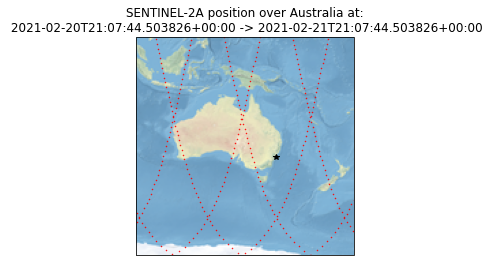

In [11]:
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([100, 180, -70, 10], ccrs.PlateCarree())
ax.stock_img()
ax.plot(ground_station.longitude.degrees, ground_station.latitude.degrees, color='black', marker='*', transform=ccrs.PlateCarree())
ax.plot(longitudes, latitudes, color='red', linestyle='', marker='.', markersize=1, transform=ccrs.PlateCarree())
ax.set_title(f'{satellite.name} position over Australia at:\n {time_list[0].isoformat()} -> {time_list[-1].isoformat()}')
plt.show()

#### 2.2.2 Finding the times when the satellite (rises, culminates, sets)

In [12]:
events_time, events_idx = satellite.find_events(ground_station, sf_time_list[0], sf_time_list[-1], altitude_degrees=0)
events_name = [ f'{satellite.name} rose above altitude 0°.',
                    f'{satellite.name} culminated.',
                    f'{satellite.name} set below altitude 0°.']

df = pd.DataFrame({
    'event idx': events_idx,
    'time': [e_t.utc_datetime() for e_t in events_time],
    'event name': [events_name[e_idx] for e_idx in events_idx]
})

df

event idx                             time  \
0           0 2021-02-20 21:45:56.533242+00:00   
1           1 2021-02-20 21:48:26.942283+00:00   
2           2 2021-02-20 21:50:57.620203+00:00   
3           0 2021-02-20 23:19:14.974612+00:00   
4           1 2021-02-20 23:26:29.508244+00:00   
5           2 2021-02-20 23:33:49.415453+00:00   
6           0 2021-02-21 00:59:20.660484+00:00   
7           1 2021-02-21 01:06:01.658349+00:00   
8           2 2021-02-21 01:12:49.657866+00:00   
9           0 2021-02-21 11:35:59.014147+00:00   
10          1 2021-02-21 11:42:43.604348+00:00   
11          2 2021-02-21 11:49:21.835381+00:00   
12          0 2021-02-21 13:14:55.835737+00:00   
13          1 2021-02-21 13:22:16.893212+00:00   
14          2 2021-02-21 13:29:32.939328+00:00   
15          0 2021-02-21 14:57:38.182276+00:00   
16          1 2021-02-21 15:00:20.977571+00:00   
17          2 2021-02-21 15:03:04.267733+00:00   

                             event name  
0   SENTINEL-2A rose above altitude 0°.  
1               SENTINEL-2A culminated.  
2    SENTINEL-2A set below altitude 0°.  
3   SENTINEL-2A rose above altitude 0°.  
4               SENTINEL-2A culminated.  
5    SENTINEL-2A set below altitude 0°.  
6   SENTINEL-2A rose above altitude 0°.  
7               SENTINEL-2A culminated.  
8    SENTINEL-2A set below altitude 0°.  
9   SENTINEL-2A rose above altitude 0°.  
10              SENTINEL-2A culminated.  
11   SENTINEL-2A set below altitude 0°.  
12  SENTINEL-2A rose above altitude 0°.  
13              SENTINEL-2A culminated.  
14   SENTINEL-2A set below altitude 0°.  
15  SENTINEL-2A rose above altitude 0°.  
16              SENTINEL-2A culminated.  
17   SENTINEL-2A set below altitude 0°.

#### 2.2.3 Satellite position on sky (altitute, azimuth, distance)

In [13]:
altaz_positions = [(satellite-ground_station).at(t).altaz() for t in sf_time_list]
altitudes = [p[0].degrees for p in altaz_positions]
azimuths = [p[1].degrees for p in altaz_positions]
distances = [p[2].km for p in altaz_positions]

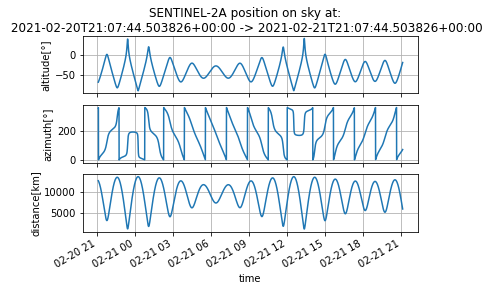

In [14]:
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_ylabel('altitude[°]')
ax1.set_xlabel('time')
ax1.plot(time_list, altitudes)
ax2 = fig.add_subplot(3, 1, 2)
ax2.set_ylabel('azimuth[°]')
ax2.set_xlabel('time')
ax2.plot(time_list, azimuths)
ax3 = fig.add_subplot(3, 1, 3)
ax3.set_ylabel('distance[km]')
ax3.set_xlabel('time')
ax3.plot(time_list, distances)
ax1.grid()
ax2.grid()
ax3.grid()
plt.gcf().autofmt_xdate()
fig.suptitle(f'{satellite.name} position on sky at:\n {time_list[0].isoformat()} -> {time_list[-1].isoformat()}')
plt.show()

In [15]:
is_visibles = [p > 0.0 for p in altitudes]

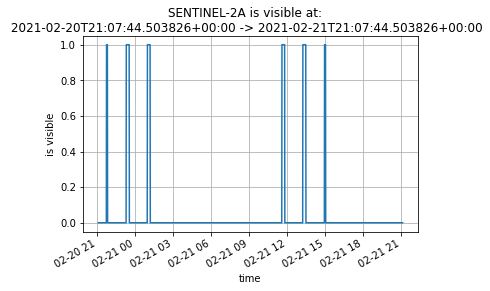

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_ylabel('is visible')
ax1.set_xlabel('time')
ax1.plot(time_list, is_visibles)
ax1.grid()
plt.gcf().autofmt_xdate()
fig.suptitle(f'{satellite.name} is visible at:\n {time_list[0].isoformat()} -> {time_list[-1].isoformat()}')
plt.show()

### 2.3 Satellite altitude referance data

#### 2.3.1 Observing Sun from the satellite's position

In [17]:
planets = sf.load('de421.bsp')
earth = planets['earth']
sun = planets['sun']

sat_sun_positions = (earth + satellite).at(sf_time_list).observe(sun)

In [18]:
sunlits = [p.is_sunlit(planets) for p in positions]

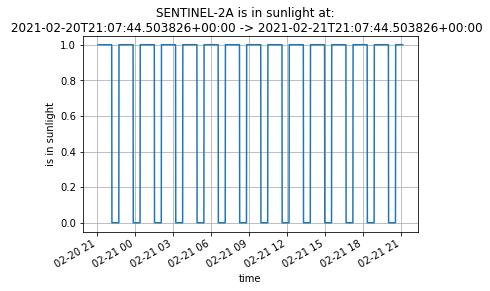

In [19]:
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
ax1.set_ylabel('is in sunlight')
ax1.set_xlabel('time')
ax1.plot(time_list, sunlits)
ax1.grid()
plt.gcf().autofmt_xdate()
fig.suptitle(f'{satellite.name} is in sunlight at:\n {time_list[0].isoformat()} -> {time_list[-1].isoformat()}')
plt.show()

#### 2.3.2 Earth magnetic field induction vector (IGRF) at the satellite position

In [20]:
def datetime2yearfloat(date: datetime):
    ms_pass = (date - datetime(year=date.year, month=1, day=1, hour=0, minute=0, second=0, microsecond=0, tzinfo=timezone.utc))
    ms_total = (datetime(year=date.year + 1, month=1, day=1, hour=0, minute=0, second=0, microsecond=0, tzinfo=timezone.utc) 
                - datetime(year=date.year, month=1, day=1, hour=0, minute=0, second=0, microsecond=0, tzinfo=timezone.utc))
    return date.year + ms_pass / ms_total

def calculate_igrf(latitude: float, longitude: float, elevation: float, date: datetime):
    """ return
         igrf_x is north component
         igrf_y is east component
         igrf_z is vertical component (+ve down)
         igrf_f is total intensity
    """
    year_float = datetime2yearfloat(date)
    d, i, h, igrf_x, igrf_y, igrf_z, igrf_f = pyIGRF.igrf_value(alt=elevation, lat=latitude, lon=longitude, year=year_float)
    return igrf_x, igrf_y, igrf_z, igrf_f

igrf_list = np.array([calculate_igrf(lat, lon, elv, t) for (lat, lon, elv, t) in zip(latitudes, longitudes, elevations, time_list)])

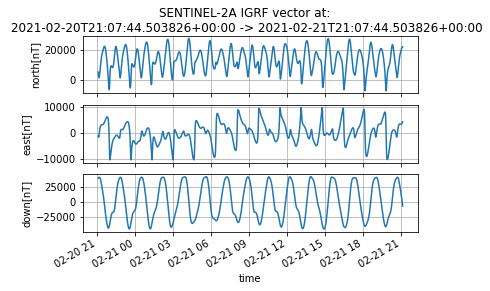

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_ylabel('north[nT]')
ax1.set_xlabel('time')
ax1.plot(time_list, igrf_list[:,0])
ax2 = fig.add_subplot(3, 1, 2)
ax2.set_ylabel('east[nT]')
ax2.set_xlabel('time')
ax2.plot(time_list, igrf_list[:,1])
ax3 = fig.add_subplot(3, 1, 3)
ax3.set_ylabel('down[nT]')
ax3.set_xlabel('time')
ax3.plot(time_list, igrf_list[:,2])
ax1.grid()
ax2.grid()
ax3.grid()
plt.gcf().autofmt_xdate()
fig.suptitle(f'{satellite.name} IGRF vector at:\n {time_list[0].isoformat()} -> {time_list[-1].isoformat()}')
plt.show()